
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.20.1?urlpath=lab/tree/tutorials/analysis/1D/spectrum_simulation.ipynb)
- You may download all the notebooks as a [tar file](../../../_downloads/notebooks-0.20.1.tar).
- **Source files:**
[spectrum_simulation.ipynb](../../../_static/notebooks/spectrum_simulation.ipynb) |
[spectrum_simulation.py](../../../_static/notebooks/spectrum_simulation.py)
</div>


# 1D spectrum simulation

## Prerequisites

- Knowledge of spectral extraction and datasets used in gammapy, see for instance the [spectral analysis tutorial](spectral_analysis.ipynb)

## Context

To simulate a specific observation, it is not always necessary to simulate the full photon list. For many uses cases, simulating directly a reduced binned dataset is enough: the IRFs reduced in the correct geometry are combined with a source model to predict an actual number of counts per bin. The latter is then used to simulate a reduced dataset using Poisson probability distribution.

This can be done to check the feasibility of a measurement, to test whether fitted parameters really provide a good fit to the data etc.

Here we will see how to perform a 1D spectral simulation of a CTA observation, in particular, we will generate OFF observations following the template background stored in the CTA IRFs.

**Objective: simulate a number of spectral ON-OFF observations of a source with a power-law spectral model with CTA using the CTA 1DC response, fit them with the assumed spectral model and check that the distribution of fitted parameters is consistent with the input values.**

## Proposed approach

We will use the following classes:

* `~gammapy.datasets.SpectrumDatasetOnOff`
* `~gammapy.datasets.SpectrumDataset`
* `~gammapy.irf.load_cta_irfs`
* `~gammapy.modeling.models.PowerLawSpectralModel`

## Setup


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation, observatory_locations
from gammapy.maps import MapAxis, RegionGeom

## Simulation of a single spectrum

To do a simulation, we need to define the observational parameters like the livetime, the offset, the assumed integration radius, the energy range to perform the simulation for and the choice of spectral model. We then use an in-memory observation which is convolved with the IRFs to get the predicted number of counts. This is Poission fluctuated using the `fake()` to get the simulated counts for each observation.  

In [3]:
# Define simulation parameters parameters
livetime = 1 * u.h

pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg

# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

on_region_radius = Angle("0.11 deg")

center = pointing.directional_offset_by(
    position_angle=0 * u.deg, separation=offset
)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=3.0,
    amplitude=2.5e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu, name="source")

PowerLawSpectralModel

  type      name     value         unit        error   min max frozen is_norm link
-------- --------- ---------- -------------- --------- --- --- ------ ------- ----
spectral     index 3.0000e+00                0.000e+00 nan nan  False   False     
spectral amplitude 2.5000e-12 cm-2 s-1 TeV-1 0.000e+00 nan nan  False    True     
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True   False     


In [5]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.04
	duration          : 3600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [7]:
# Make the SpectrumDataset
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="obs-0"
)
maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])

dataset = maker.run(dataset_empty, obs)

In [8]:
# Set the model on the dataset, and fake
dataset.models = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 298 
  Total background counts         : 22.29
  Total excess counts             : 275.71

  Predicted counts                : 303.66
  Predicted background counts     : 22.29
  Predicted excess counts         : 281.37

  Exposure min                    : 2.53e+08 m2 s
  Exposure max                    : 1.77e+10 m2 s

  Number of total bins            : 9 
  Number of fit bins              : 9 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1811.58

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                         :      3.

You can see that background counts are now simulated

### On-Off analysis

To do an on off spectral analysis, which is the usual science case, the standard would be to use `SpectrumDatasetOnOff`, which uses the acceptance to fake off-counts 

In [9]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)
dataset_on_off.fake(npred_background=dataset.npred_background())
print(dataset_on_off)

SpectrumDatasetOnOff
--------------------

  Name                            : HEEdFEpA 

  Total counts                    : 314 
  Total background counts         : 22.40
  Total excess counts             : 291.60

  Predicted counts                : 303.82
  Predicted background counts     : 22.45
  Predicted excess counts         : 281.37

  Exposure min                    : 2.53e+08 m2 s
  Exposure max                    : 1.77e+10 m2 s

  Number of total bins            : 9 
  Number of fit bins              : 9 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.32

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                       

You can see that off counts are now simulated as well. We now simulate several spectra using the same set of observation conditions.

In [10]:
%%time

n_obs = 100
datasets = Datasets()

for idx in range(n_obs):
    dataset_on_off.fake(
        random_state=idx, npred_background=dataset.npred_background()
    )
    dataset_fake = dataset_on_off.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    datasets.append(dataset_fake)

CPU times: user 2.36 s, sys: 43.2 ms, total: 2.41 s
Wall time: 2.67 s


In [11]:
table = datasets.info_table()
table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
obs-0,317,298.6000061035156,27.08240180813126,18.399999618530273,68.16666751313541,68.16666751313541,nan,252718176.0,17719697408.0,3600.000000000002,3600.000000000002,0.08805555555555551,0.0051111110051472956,0.08294444613986542,9,9,wstat,738.7245834271496,92,9.0,45.0,0.20000000298023224
obs-1,275,253.0,23.76785365487285,22.0,64.16666666666669,64.16666666666669,nan,252718170.97287694,17719697919.59929,3600.000000000002,3600.000000000002,0.07638888888888885,0.006111111111111108,0.07027777777777774,9,9,wstat,575.779512784738,110,9.0,45.0,0.2
obs-2,293,272.4,25.17110555404655,20.6,66.0,66.0,nan,252718170.97287694,17719697919.59929,3600.000000000002,3600.000000000002,0.08138888888888884,0.00572222222222222,0.07566666666666662,9,9,wstat,645.4993824075303,103,9.0,45.0,0.2
obs-3,280,257.6,23.982951737405354,22.4,65.33333333333334,65.33333333333334,nan,252718170.97287694,17719697919.59929,3600.000000000002,3600.000000000002,0.07777777777777774,0.006222222222222218,0.07155555555555553,9,9,wstat,585.9241546985872,112,9.0,45.00000000000001,0.19999999999999998
obs-4,337,316.4,27.682709945184747,20.6,73.33333333333334,73.33333333333334,nan,252718170.97287694,17719697919.59929,3600.000000000002,3600.000000000002,0.09361111111111106,0.00572222222222222,0.08788888888888884,9,9,wstat,787.314723949448,103,9.0,45.0,0.2
obs-5,283,258.6,23.727154782347895,24.400000000000002,67.50000000000001,67.50000000000001,nan,252718170.97287694,17719697919.59929,3600.000000000002,3600.000000000002,0.07861111111111108,0.006777777777777775,0.0718333333333333,9,9,wstat,574.8525737727499,122,9.0,45.0,0.2
obs-6,330,307.6,26.889184475727866,22.400000000000006,73.66666666666667,73.66666666666667,nan,252718170.97287694,17719697919.59929,3600.000000000002,3600.000000000002,0.09166666666666662,0.006222222222222221,0.0854444444444444,9,9,wstat,734.2414755285937,112,9.0,44.99999999999999,0.20000000000000004
obs-7,283,257.2,23.43087974795853,25.8,68.66666666666667,68.66666666666667,nan,252718170.97287694,17719697919.59929,3600.000000000002,3600.000000000002,0.07861111111111108,0.007166666666666663,0.07144444444444441,9,9,wstat,552.3698779448044,129,9.0,45.0,0.2


Before moving on to the fit let's have a look at the simulated observations.

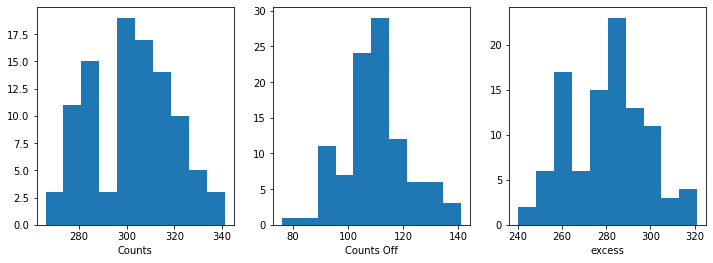

In [12]:
fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(table["counts"])
axes[0].set_xlabel("Counts")
axes[1].hist(table["counts_off"])
axes[1].set_xlabel("Counts Off")
axes[2].hist(table["excess"])
axes[2].set_xlabel("excess");

Now, we fit each simulated spectrum individually 

In [13]:
%%time
results = []

fit = Fit()

for dataset in datasets:
    dataset.models = model.copy()
    result = fit.optimize(dataset)
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )

CPU times: user 40.7 s, sys: 247 ms, total: 40.9 s
Wall time: 45.1 s


We take a look at the distribution of the fitted indices. This matches very well with the spectrum that we initially injected.

index: 3.003692555041602 += 0.08081469526978655


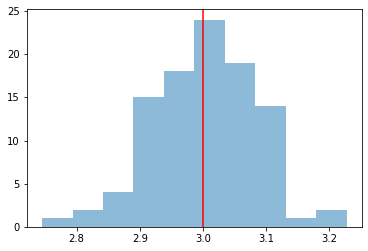

In [14]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
print(f"index: {index.mean()} += {index.std()}")

## Exercises

* Change the observation time to something longer or shorter. Does the observation and spectrum results change as you expected?
* Change the spectral model, e.g. add a cutoff at 5 TeV, or put a steep-spectrum source with spectral index of 4.0
* Simulate spectra with the spectral model we just defined. How much observation duration do you need to get back the injected parameters?